# Humboldt Current Misc. Detective Work

While writing the paper, I was discussing how there is a large reduction in sDIC in the Humboldt Current. I assumed that this was due to a reduction in upwelling-favorable winds associated with ENSO. However, after regressing the ensemble TAUX, TAUY, and U onto ENSO, I found that U increased, and upwelling-favorable TAUX/TAUY increased. However, WVEL decreased. There's something wrong here.

I'll try 2 approaches to figure this out:

(1) Reconstruct wind stress curl and regress that to see if the curl structure changes

(2) Do a composite of TAUX/TAUY residuals and see what they look like as a quiver plot

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import cartopy.crs as ccrs
plt.style.use('ocn-clim')
import cartopy.feature as cfeature
import seaborn as sns
import glob
from scipy import signal

## (1) Wind Stress Curl

In [15]:
def load_overhead_correlations(EBU, x, y, lag, smooth):
    """
    Loads in the results of the overhead correlation analysis that was
    run as a python script.
    
    EBU       : Acronym for the EBUS of interest.
    x         : Predictor variable for the gas flux (e.g. NPGO)
    y         : Dependent variable being predicted (e.g. FG_CO2, U)
    lag       : Lag in months applied
    smooth    : Smooth in months applied
    """
    filedir = '/glade/p/work/rbrady/EBUS_BGC_Variability/regional_regressions/'
    filepath = filedir + EBU + '/' + y + '/' + x + '/lag' + str(lag) + '/'
    if smooth == 0:
        filename = (filepath + x + '.' + y + '.' + EBU + 
                    '.*.unsmoothed_regional_regression.lag' +
                    str(lag) + '.nc')
    else:
        filename = (filepath + x + '.' + y + '.' + EBU + 
                    '.*.smoothed' + str(smooth) + '_regional_regression.lag' +
                    str(lag) + '.nc')
    ds = xr.open_mfdataset(filename, concat_dim='ensemble')
    return ds

In [42]:
ds = load_overhead_correlations('HumCS', 'NINO3', 'curl', 0, 0)
mask = ds['r'].sel(ensemble=0) # Use to re-nan things that aren't in region.
#ds = ds.where(ds.p <= 0.1, -999)
ds = ds.mean('ensemble')

In [ ]:
f, ax = et.vis.make_cartopy(projection=ccrs.Mercator(), frameon=False, grid_lines=False)

data = ds['r']
data = np.ma.array(data, mask=np.isnan(mask))
cmap = plt.cm.RdBu_r
p = ax.pcolor(ds['lon']-1, ds['lat'], data,
                  transform=ccrs.PlateCarree(), edgecolor='w',
                 cmap=cmap)
ax.outline_patch.set_edgecolor('w')

# Aesthetics
x1,x2,y1,y2 = et.ebus.visual_bounds('HumCS')
ax.set_extent([x1,x2,y1,y2])

# Colorbar
cb = plt.colorbar(p)
ax.set_title('HumCS' + ' Corr(' + 'curl' + ',' + 'Nino3' + ') Ensemble Mean',
             fontsize=18)

#et.vis.savefig('humcs_grid_curl_nino3', extension='.eps', dpi=300)

## (2) Composite of Residuals

Adapting from full python script.

In [45]:
EBU = 'HumCS'
index = 'NINO3'
VAR = 'SST'

In [90]:
def composite_domain(ebus):
    """
    Returns latitude and longitude coordinates for slicing out the composite
    domain.
    """
    if ebus == 'HumCS':
        x0 = 180
        x1 = 300
        y0 = -30
        y1 = 15
    else:
        raise Exception("Need to add composite domain for other EBU's.")
    return x0, x1, y0, y1

In [91]:
def xarray_month_count(time_index, name):
    """
    Takes in a time-varying field with ensemble members after filtering for the
    two-sigma or whatever significance bounds. Converts these into a 
    DataArray with month dimension 1-12 and values for the number of pos/neg/
    neutral events for each month.
    """
    stacked_months = time_index.stack(points=['ensemble','time']) \
                               .dropna('points')['time.month']
    df = stacked_months.to_dataframe()
    df = df.groupby('month').size()
    df = df.to_xarray()
    df.name = name
    return df

In [92]:
# Load in CVDP
filepath = '/glade/p/work/rbrady/cesmLE_CVDP/processed/cvdp_detrended_BGC.nc'
cvdp = xr.open_dataset(filepath)
cvdp = cvdp[index.lower()]
two_sigma = cvdp.std() * 2

In [93]:
# Load in residual data
filepath = ('/glade/p/work/rbrady/EBUS_BGC_Variability/global_residuals/' + 
            VAR + '/remapped/')
ds_var = xr.open_mfdataset(filepath + '*.nc', concat_dim='ensemble')
ds_var = ds_var[VAR]
ds_var['time'] = pd.date_range('1920-01', '2016-01', freq='M')
x0, x1, y0, y1 = composite_domain(EBU)
ds_var = ds_var.sel(lat=slice(y0, y1), lon=slice(x0, x1))

In [98]:
pos_time_index = cvdp.where(cvdp >= two_sigma, drop=True)
neg_time_index = cvdp.where(cvdp <= two_sigma*-1, drop=True)
neu_time_index = cvdp.where( (cvdp < two_sigma) & (cvdp > two_sigma*-1), drop=True)

In [100]:
pos_months = xarray_month_count(pos_time_index, 'pos_months')
neg_months = xarray_month_count(neg_time_index, 'neg_months')
neu_months = xarray_month_count(neu_time_index, 'neu_months')

In [101]:
pos_composite = ds_var.where(cvdp >= two_sigma).mean('ensemble').mean('time')
neg_composite = ds_var.where(cvdp <= two_sigma*-1).mean('ensemble').mean('time')
neu_composite = ds_var.where( (cvdp < two_sigma) & (cvdp > two_sigma*-1) ) \
                .mean('ensemble').mean('time')

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


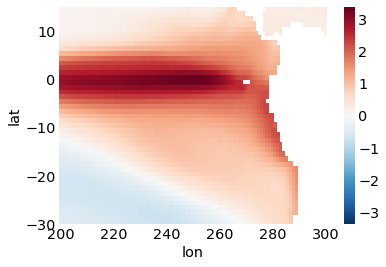

In [103]:
pos_composite.plot()

## Temp

In [105]:
ds = xr.open_dataset('/glade/p/work/rbrady/EBUS_BGC_Variability/global_residuals/SST/remapped/remapped.SST.001.192001-201512.nc')
ds = ds.sel(lat=slice(-30,15), lon=slice(180,300)).mean('time')['SST']

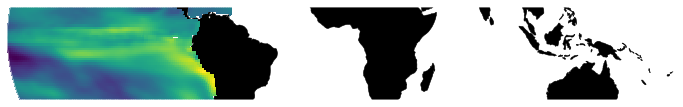

In [106]:
f, ax = et.vis.make_cartopy(projection=ccrs.Robinson(), frameon=False, grid_lines=False)
ax.pcolormesh(ds['lon'], ds['lat'], ds, transform=ccrs.PlateCarree())


#data = ds['r']
#data = np.ma.array(data, mask=np.isnan(mask))
#cmap = plt.cm.RdBu_r
#p = ax.pcolor(ds['lon']-1, ds['lat'], data,
#                  transform=ccrs.PlateCarree(), edgecolor='w',
#                 cmap=cmap)
#ax.outline_patch.set_edgecolor('w')

# Aesthetics
#x1,x2,y1,y2 = et.ebus.visual_bounds('HumCS')
#ax.set_extent([x1,x2,y1,y2])

# Colorbar
#cb = plt.colorbar(p)
#ax.set_title('HumCS' + ' Corr(' + 'curl' + ',' + 'Nino3' + ') Ensemble Mean',
#             fontsize=18)

#et.vis.savefig('humcs_grid_curl_nino3', extension='.eps', dpi=300)